# *Projet Python ENSAE*

## Tokenisation d'actifs immobiliers - partie valorisation

Le but de ce notebook principal est de **créer un modèle de valorisation des actifs immobiliers**. Pour cela, nous utilisons principalement les données extraites du **dataset Demande de Valeurs Foncières** (DVF) et des **données INSEE**. Nous nous sommes inspirés d'un projet d'Arnaud Hureaux que nous avons cherché ) approfondir et compléter.

Lien projet (source d'inspiration) : https://hureauxarnaud.medium.com/projet-estimateur-de-prix-dun-bien-immobilier-bas%C3%A9-sur-du-machine-learning-ae578fdacaca

# Plan du notebook

**Etape 0 : packages**

**Etape 1 : preprocessing**

* 1.1. Importation du dataset DVF
* 1.2. Visualisation des données DVF
* 1.3. Création du dataset final DVF
* 1.4. Valeurs extrêmes dans le dataset DVF

**Etape 2 : feature engineering**

* 2.1. Choix des nouveaux features
* 2.2. Importation des nouveaux features
* 2.3. Jointure des deux bases de données

**Etape 3 : analyse descriptive**

* 3.1. premières analyses
* 3.2. Analyse de la répartition des prix de vente
* 3.3. Analyse de la corrélation entre surface et prix de vente
* 3.4. Premières intuitions sur l'analyse à l'échelle d'un département

**Etape 4 : modélisation**

# Etape 0 : packages

In [77]:
# Importation des packages importants

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.neighbors import BallTree
import requests
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
!pip install nltk
from nltk.metrics.distance import jaro_winkler_similarity
from scipy.spatial.distance import cdist
!pip install unidecode
import unidecode
import zipfile
from urllib.request import urlopen
import shutil
import os
!pip install statsmodels
import statsmodels.api as sm
from scipy import stats
!pip install geopandas
import geopandas as gpd
!pip install folium
import folium

     |████████████████████████████████| 1.0 MB 1.6 MB/s            
     |████████████████████████████████| 15.4 MB 15.9 MB/s            
     |████████████████████████████████| 1.1 MB 29.6 MB/s            
     |████████████████████████████████| 5.8 MB 13.6 MB/s            
     |████████████████████████████████| 95 kB 1.5 MB/s            


In [2]:
# Importation de données externes traitées dans un autre fichier
# Voire partie 2 (features) & le notebook external_data
!pip install import-ipynb
import import_ipynb
from external_data import retrieve_data

  Preparing metadata (setup.py) ... done
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=c996b2b3494ad280c68f61edcc2231f86114ee6e03de22e50802e3ea4375fc5d
  Stored in directory: /home/jovyan/.cache/pip/wheels/14/d1/f8/04883e42b40c1d3d24cb6579b16c63d4735bb1c8b82c5d29e3
Successfully built import-ipynb
importing Jupyter notebook from external_data.ipynb
     |████████████████████████████████| 242 kB 1.4 MB/s            


<string>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,nom_dep,nb_musees,code_dep
0,AIN,14,01
1,AISNE,15,02
2,ALLIER,9,03
3,ALPES DE HAUTE PROVENCE,9,04
4,ALPES-MARITIMES,33,06
...,...,...,...
96,VENDEE,14,85
97,VIENNE,12,86
98,VOSGES,7,88
99,YONNE,12,89


,Libelle,2016-T1,2016-T2,2016-T3,2016-T4,2017-T1,2017-T2,2017-T3,2017-T4,2018-T1,...,2020-T3,2020-T4,2021-T1,2021-T2,2016,2017,2018,2019,2020,2021
0,France,9.9,9.8,9.6,9.7,9.3,9.2,9.3,8.7,8.9,...,8.9,7.8,7.8,7.8,9.750,9.125,8.700,8.175,7.850,7.80
1,Île-de-France,8.8,8.7,8.6,8.8,8.3,8.2,8.3,7.9,8.1,...,8.4,7.7,7.7,7.6,8.725,8.175,7.925,7.400,7.350,7.65
2,Centre-Val,9.7,9.5,9.4,9.4,9.0,9.0,8.9,8.4,8.6,...,8.3,7.1,7.2,7.2,9.500,8.825,8.450,8.050,7.400,7.20
3,Pays,8.8,8.5,8.4,8.4,8.0,7.9,7.9,7.3,7.6,...,8.0,6.7,6.8,6.7,8.525,7.775,7.375,7.050,7.000,6.75
4,Bretagne,8.8,8.6,8.4,8.6,8.1,8.0,8.0,7.5,7.7,...,7.7,6.6,6.6,6.5,8.600,7.900,7.500,6.975,6.775,6.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,Var,11.1,10.8,10.7,11.0,10.6,10.4,10.4,9.9,10.2,...,9.7,8.2,8.4,8.6,10.900,10.325,9.925,9.200,8.575,8.50
110,Guadeloupe,25.6,25.1,21.5,20.6,21.6,22.9,21.4,22.5,23.5,...,18.9,19.4,17.5,19.2,23.200,22.100,22.025,20.125,16.850,18.35
111,Martinique,19.8,19.7,19.1,17.4,19.4,19.2,18.3,17.3,16.5,...,16.4,15.0,12.7,14.7,19.000,18.550,18.475,16.150,13.050,13.70
112,Guyane,19.4,19.8,22.8,19.1,18.7,20.4,20.5,18.1,15.8,...,17.1,17.8,12.5,13.8,20.275,19.425,16.825,17.125,14.125,13.15


,code_dep,nom_dep,chomage_2016,chomage_2017,chomage_2018,chomage_2019,chomage_2020,chomage_2019
1,01,Ain,7.35,6.775,6.325,6.050,6.075,6.05
2,02,Aisne,13.80,13.175,12.575,11.775,11.125,11.15


99


Il y a 99 départements représentés.


# Etape 1 : preprocessing DVF

### 1.1. Importation du dataset DVF :

Nous importons le dataset « **Demandes de valeurs foncières** » (DVF), publié par la DGFiP, permet de connaître les transactions immobilières intervenues au cours des cinq dernières années sur le territoire métropolitain et les DOM-TOM, à l’exception de l’Alsace, de la Moselle et de Mayotte. Les données contenues sont issues des actes notariés et des informations cadastrales.

Fichiers 2017-2020 : https://files.data.gouv.fr/geo-dvf/latest/

In [3]:
# Les fichiers sont issus de https://files.data.gouv.fr/geo-dvf/latest/

name = "https://files.data.gouv.fr/geo-dvf/latest/csv/2021/full.csv.gz"
table = pd.read_csv(name, sep = ',')

# On ne travaille que sur les données du S1 2021, afin d'avoir des calculs moins coûteux en temps.
# Les transactions du S1 2021 représentent tout de même un dataset de 1 200 000 lignes...
# Pour travailler sur l'ensemble des données (2017-2021), il suffit d'enlever les guillemets ci-dessous.

"""
for year in range(2017, 2021):
    name = "https://files.data.gouv.fr/geo-dvf/latest/csv/" + str(year) + "/full.csv.gz"
    table = pd.concat([table, pd.read_csv(name, sep = ',')])

display("Taille de table :")
display(table.shape)
table.head()
"""

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (10,12,17,18,20,22,24,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


'\nfor year in range(2017, 2021):\n    name = "https://files.data.gouv.fr/geo-dvf/latest/csv/" + str(year) + "/full.csv.gz"\n    table = pd.concat([table, pd.read_csv(name, sep = \',\')])\n\ndisplay("Taille de table :")\ndisplay(table.shape)\ntable.head()\n'

### 1.2. Visualisation des données DVF

Il s'agit dans cette section de se faire **des premières intuitions sur les données**. 

En particulier, on se rend compte d'un **problème de preprocessing** : une transaction peut correspondre à plusieurs lignes avec la même valeur foncière sur chaque ligne. Autrement dit, **DVF affiche le même prix de vente global à chaque lot d'une même transaction**.

Pour observer cela, nous allons créer **un identifiant de transaction unique**.

In [4]:
# Création d'une adresse générique

table['adresse_numero'] = table['adresse_numero'].fillna('0').astype(int)
table['adresse_suffixe'] = table['adresse_suffixe'].fillna(' ')
table['adresse_code_voie'] = table['adresse_code_voie'].fillna(' ')
table['adresse_nom_voie'] = table['adresse_nom_voie'].fillna(' ')
table['code_postal'] = table['code_postal'].fillna('0').astype(int)
table['nom_commune'] = table['nom_commune'].fillna(' ')

#Ajout de "\" pour que l'opération soit visible à l'écran en entier
table["adresse"] = table['adresse_numero'].astype(str) + ' ' + table['adresse_suffixe'] + ' ' + \
                table['adresse_code_voie'] + ' ' + table['adresse_nom_voie'] + ' ' + table['nom_commune'] + ' ' + \
                table['code_postal'].astype(str) + ' ' + 'France'

# Création d'un identifiant de transaction

# Pour identifier les doublons, l'adresse ne suffit pas : un bien peut avoir été vendu deux fois dans la même année
table["identifiant_transaction"] = table["adresse"].astype(str) + ' le ' + table["date_mutation"].astype(str)

In [5]:
# Problème dans les données et vérification de la validité de l'identifiant de transaction :

display(table["identifiant_transaction"].loc[0])
display(table["identifiant_transaction"].loc[1])
display("Si l'identifiant de transaction est valide, alors True doit s'afficher :")
table["identifiant_transaction"].loc[0] == table["identifiant_transaction"].loc[1]

'5080   0471 CHE DE VOGELAS Val-Revermont 1370 France le 2021-01-05'

'5080   0471 CHE DE VOGELAS Val-Revermont 1370 France le 2021-01-05'

"Si l'identifiant de transaction est valide, alors True doit s'afficher :"

True

In [7]:
# On constate, encore une fois, le problème relevé ci-dessus :

display("Nombre d'adresses uniques dans le DataFrame :")
display(len(table["adresse"].unique()))

display("Nombre d'identifiant_transaction uniques dans le DataFrame :")
display(len(table["identifiant_transaction"].unique()))

display("Nombre de lignes dans le DataFrame :")
display(len(table))

display("Nombre moyen de lignes par vente :")
np.round(len(table) / len(table["identifiant_transaction"].unique()), 2)

# Une vente correspond à plusieurs lignes, les informations sont donc diffusées dans ces lignes...

"Nombre d'adresses uniques dans le DataFrame :"

547234

"Nombre d'identifiant_transaction uniques dans le DataFrame :"

654843

'Nombre de lignes dans le DataFrame :'

1210569

'Nombre moyen de lignes par vente :'

1.85

Dès lors, si on entraîne l'algorithme de pricing sur ce dataset, il sera **biaisé** : 
* d'une part, il associerait à une dépendance de 20 m2 le prix d'un appartement de 200 m2
* d'autre part, il ne prendrait pas en compte la plus-value apportée par un jardin à une maison, par une dépendance à un appartement, etc.

Il conviendra donc de **retravailler les données pour obtenir une seule ligne par transaction**.

**Le notebook "cleaning-dvf"** (lien : https://github.com/victor-kerros/tokenisation-immo/blob/main/cleaning-dvf.ipynb) revient en détail sur ce problème de preprocessing et effectue ce travail de nettoyage. Dans la mesure où cette solution de nettoyage est très coûteuse en temps, nous privilégions **une solution plus efficace** dans le cadre de ce projet : nous ne retenons que les transactions ne faisant l'objet que d'une seule ligne.

### 1.3. Création du dataset final DVF

D'abord, nous ne prenons que les colonnes suivantes :
- Date de vente/mutation
- Nature mutation (pour séparer les ventes en VEFA et les ventes classiques)
- Valeur foncière (prix de vente)
- Colonnes liées à l’adresse (pour nous permettre de localiser le bien)
- Adresse
- Code Postal
- Type local (maison/appartement/Local commercial/Dépendance etc)
- Surface réelle bâtie (nb de mètre carré du bien bâti)
- Surface terrain (nb de mètre carré du terrain associé au bien)

In [8]:
# On crée le dataframe table_vf avec les seules colonnes qui nous intéressent
colonnes = ["date_mutation", "nature_mutation", "valeur_fonciere", "code_postal", 'type_local',
            'surface_reelle_bati', 'nombre_pieces_principales', 'nature_culture', 'surface_terrain', 'longitude', 
            'latitude', 'adresse', 'code_departement', 'identifiant_transaction']
table_vf = table[colonnes].copy()

# On agrège les types de cultures différents de NaN, sols, terrain à bâtir et  : on les renomme "culture"
culture_type = ['taillis simples', 'eaux', 'landes', 'taillis sous futaie', 'prés', 'terres', 'peupleraies', 
                'vignes', 'bois', 'vergers', 'carrières', 'futaies résineuses', 'pâtures', 'futaies feuillues', 
                'futaies mixtes', 'chemin de fer', 'oseraies', 'pacages', 'prés plantes', 'terres plantées', 
                'landes boisées', 'herbages', "prés d'embouche"]

for x in culture_type:
    table_vf.loc[table_vf["nature_culture"] == x, "nature_culture"] = "culture"

Ensuite, comme annoncé, nous ne retenons que les transactions ne faisant l'objet que d'une seule ligne pour créer "data" : le dataset final avec lequel nous allons travailler.

In [9]:
# On ne retient que les transactions ayant fait l'objet d'une seule et unique ligne
table_vf_dup = table_vf.copy()
table_vf_uni = table_vf.copy()

# On récupère les indices des transactions dupliquées...
# i.e. les lignes où on retrouve un id de transaction utilisé ailleurs
dup_id = table_vf_dup.groupby('identifiant_transaction').size()
dup_id = dup_id[dup_id > 1]
dup_id = dup_id.reset_index()

table_vf_dup = table_vf_dup[table_vf_dup['identifiant_transaction'].isin(dup_id["identifiant_transaction"])]
table_vf_uni = table_vf_uni[~table_vf_uni['identifiant_transaction'].isin(dup_id["identifiant_transaction"])]

print("Taille de table_vf_uni (nombre de transactions non dupliquées) :")
print(table_vf_uni.shape)

# La solution la plus efficace, pour éviter un nettoyage trop coûteux en temps...
# est de ne retenir que les transactions non dupliquées.
data = table_vf_uni
data = data.reset_index().drop("index", axis = 1)

# Visualisation de data
display("Les trois premières lignes de data :")
display(data.head(3))

Taille de table_vf_uni (nombre de transactions non dupliquées) :
(387469, 14)


'Les trois premières lignes de data :'

,date_mutation,nature_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,code_departement,identifiant_transaction
0,2021-01-06,Vente,10.0,1290,NaN,NaN,NaN,culture,530.0,4.844368,46.224233,0 B043 ROUGEMONT Bey 1290 France,1,0 B043 ROUGEMONT Bey 1290 France le 2021-01-06
1,2021-01-04,Vente,204332.0,1310,Maison,88.0,4.0,sols,866.0,5.157688,46.200988,7 0276 ALL DES ECUREUILS Buellas 1310 France,1,7 0276 ALL DES ECUREUILS Buellas 1310 France...
2,2021-01-04,Vente,36.3,1250,NaN,NaN,NaN,culture,121.0,5.462947,46.256243,0 B077 COMBET MAILLET Corveissiat 1250 France,1,0 B077 COMBET MAILLET Corveissiat 1250 Franc...


### 1.4. Valeurs extrêmes dans le dataset DVF

On s'intéresse aux **valeurs extrêmes dans le dataset**. En effet, afin d'avoir un entraînement fiable, nous devons les enlever (sinon, il y aura trop de bruit).

In [10]:
def boxplot_display(data):

    fig, axs = plt.subplots(1,4)
    fig.suptitle("Boxplot des variables d'intérêt :")

    axs[0].boxplot(data[data['valeur_fonciere'].notna()]['valeur_fonciere'])
    axs[0].set(title = "Valeurs foncières")

    axs[1].boxplot(data[data['surface_reelle_bati'].notna()]['surface_reelle_bati'])
    axs[1].set(title = "Surface bati")

    axs[2].boxplot(data[data['nombre_pieces_principales'].notna()]['nombre_pieces_principales'])
    axs[2].set(title = "Nbre pièces")

    axs[3].boxplot(data[data['surface_terrain'].notna()]['surface_terrain'])
    axs[3].set(title = "Surface terrain")

    fig.tight_layout()

    plt.show()

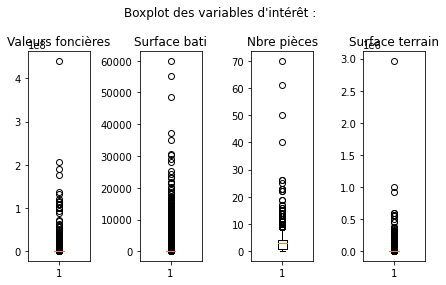

In [11]:
boxplot_display(data)

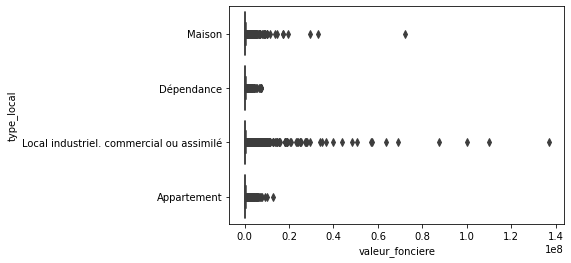

In [12]:
ax = sns.boxplot(x = "valeur_fonciere", y = "type_local", data = data)

On constate sur ces boxplots que le dataset présente des valeurs extrêmes **particulièrement hautes** dans les quatre variables d'intérêt. 

En particulier, les locaux industriels, commerciaux et assimilés ont des valeurs extrêmes très importantes.

On observe également des valeurs extrêmes **particulièrement basses**, comme le montrent les cellules ci-dessous.

In [13]:
display(len(data["valeur_fonciere"]))
valeurs = [1.0, 10.0, 1000.0, 5000.0, 10000.0]
for i in valeurs:
    display("Le nombre de valeurs foncières inférieures ou égales à "+str(i)+" est de:")
    display(sum(data["valeur_fonciere"] <= i))

387469

'Le nombre de valeurs foncières inférieures ou égales à 1.0 est de:'

2315

'Le nombre de valeurs foncières inférieures ou égales à 10.0 est de:'

2500

'Le nombre de valeurs foncières inférieures ou égales à 1000.0 est de:'

13637

'Le nombre de valeurs foncières inférieures ou égales à 5000.0 est de:'

31482

'Le nombre de valeurs foncières inférieures ou égales à 10000.0 est de:'

42564

In [14]:
display(len(data["surface_reelle_bati"]))
valeurs = [1.0, 5.0, 10.0, 30.0]
for i in valeurs:
    display("Le nombre de surfaces bati intérieures ou égales à "+str(i)+" est de:")
    display(sum(data["surface_reelle_bati"] <= i))

387469

'Le nombre de surfaces bati intérieures ou égales à 1.0 est de:'

21

'Le nombre de surfaces bati intérieures ou égales à 5.0 est de:'

62

'Le nombre de surfaces bati intérieures ou égales à 10.0 est de:'

496

'Le nombre de surfaces bati intérieures ou égales à 30.0 est de:'

17006

On constate que bien qu'il n'y ait pas de valeurs foncières nulle, il y en a **de nombreuses qui sont inférieures ou égales à 10**.
On considère qu'**une transaction est crédible lorsque la valeur foncière est supérieure à 5000** (en-dessous, il s'agit d'une vente qui ne nous intéresse pas).

De même, pn considère qu'**une transaction est crédible lorsque la surface du bâtiment est supérieure à 10 m2**.

In [15]:
# D'abord, on écarte les valeurs foncières inférieures à 5000 et les surface_reelle_bati inférieures à 10 m2

data = data[data["valeur_fonciere"] > 4999]

data = data[data["surface_reelle_bati"] > 9]

In [16]:
# Il n'y a plus de Dépendances dans le dataset...

data["type_local"].unique()

array(['Maison', 'Local industriel. commercial ou assimilé',
       'Appartement'], dtype=object)

In [17]:
data.drop(["code_postal", "longitude", "latitude"], axis = 1).describe()

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain
count,2.089620e+05,208962.000000,208962.000000,131713.000000
mean,2.453215e+05,108.507446,3.401489,579.178654
std,7.371912e+05,443.792462,1.731744,1495.270241
min,5.000000e+03,10.000000,0.000000,1.000000
25%,1.050000e+05,56.000000,2.000000,209.000000
50%,1.730000e+05,80.000000,4.000000,412.000000
75%,2.800000e+05,105.000000,4.000000,676.000000
max,1.369470e+08,60000.000000,70.000000,278931.000000


Par ailleurs, on observe avec le describe ci-dessus que **les écart-types sont très importants par rapport aux moyennes**, surtout pour les variables "valeur_fonciere", "surface_reelle_bati" et "surface_terrain".
Donc, **on enlève les valeurs trop hautes** : ici, cela consiste à *enlever les valeurs dont l'écart à la moyenne en valeur absolue est supérieure à 4 fois l'écart-type*.

In [18]:
# Pour valeur_fonciere :
data = data[~(np.abs(data['valeur_fonciere'] - data['valeur_fonciere'].mean()) > (4 * data['valeur_fonciere'].std()))]

# Pour surface_reelle_bati :
data = data[~(np.abs(data['surface_reelle_bati'] - data['surface_reelle_bati'].mean()) > (4 * data['surface_reelle_bati'].std()))]

# Pour surface_terrain :
data = data[~(np.abs(data['surface_terrain'] - data['surface_terrain'].mean()) > (4 * data['surface_terrain'].std()))]

In [19]:
data.drop(["code_postal", "longitude", "latitude"], axis = 1).describe()

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain
count,2.074130e+05,207413.000000,207413.000000,130343.000000
mean,2.275776e+05,90.073877,3.416883,508.939659
std,2.186373e+05,80.755483,1.715642,456.711799
min,5.000000e+03,10.000000,0.000000,1.000000
25%,1.050000e+05,55.000000,2.000000,207.000000
50%,1.720000e+05,80.000000,4.000000,408.000000
75%,2.780000e+05,105.000000,4.000000,666.000000
max,3.190000e+06,1609.000000,70.000000,4247.000000


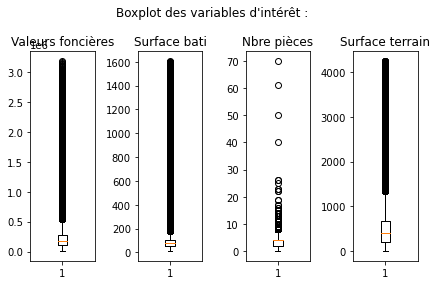

In [20]:
boxplot_display(data)

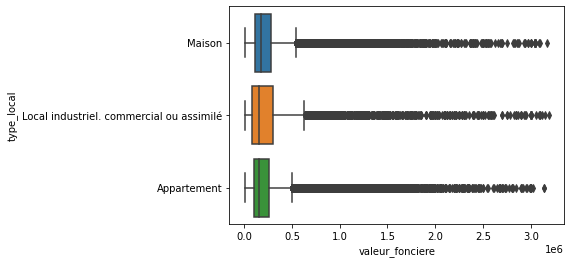

In [21]:
ax = sns.boxplot(x = "valeur_fonciere", y = "type_local", data = data)

**Ces boxplots correspondent davantage avec la réalité** (médiane des ventes autour de 150 000 euros).

# Etape 2 : feature engineering

### 2.1. Choix des nouveaux features :

Afin d'**avoir un modèle performant**, nous allons **ajouter d'autres features**. En effet, la localisation, le prix, le nombre de pièces et la surface ne donnent pas assez d'informations pour bien valoriser un bien immobilier.

Selon BSI Economics, **trois facteurs** qui influencent les prix de l'immobilier :

- **l'environnement économique et financier** (offre et demande de logement, contexte économie, structure des marchés immobiliers, logements neufs et anciens, démographie, taux de logements vacants) ;

- **les conditions d'emprunts** (taux variables/fixes, maturités des prêts, ratio emprunt sur valeur, répartition des crédits, solvabilité, système de garantie) ;

- **l'environnement fiscal** (mesures fiscales incitatives à la location, distorsion fiscale des locataires vers les propriétaires).

En particulier, **un agent immobilier** observe, par exemple, les features suivant :
* prix au m2 du quartier (le projet qui nous a inspiré utilise l'algorithme BallTree pour l'obtenir), 
* PIB du département (mesure de l'activité économique des alentours), 
* densité du département (mesure de l'urbanisation, de l'activité), 
* variation de population non naturelle (mesure de l'attractivité),
* mois de la transaction (saisonnalité des prix dans certaines régions touristiques), 
* taux de logements vacants dans la région (mesure de l'attractivité).

### 2.2. Importation des nouveaux features :

In [22]:
# Creation de la variable prix_m2 :

data['prix_m2'] = data['surface_terrain'] / data['valeur_fonciere']

Ces features ont été **générées dans le ntebook "external-data"**. Nous invitons le lecteur à s'y référer afin d'apprécier la manière dont ils ont été importés puis préprocessés.

In [23]:
# Importation des données externes INSEE :

#Old via excel
#file_path = "https://github.com/victor-kerros/tokenisation-immo/raw/main/external-data.csv"
#external_data = pd.read_csv(file_path, sep = ",")

external_data = retrieve_data()
external_data.head(3)

,code_dep,nom_dep,tx_natalite_2020_percent,nb_musees,chomage_2016,chomage_2017,chomage_2018,chomage_2019,chomage_2020,chomage_2019,taux_vacances_2019
0,01,Ain,10.3,14,7.350,6.775,6.325,6.050,6.075,6.05,10.066116
1,02,Aisne,10.1,15,13.800,13.175,12.575,11.775,11.125,11.15,10.998363
2,03,Allier,7.8,9,10.525,9.900,9.525,9.050,8.650,8.45,14.294594


In [24]:
list_numbers = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]
data["code_departement"] = data["code_departement"].apply(
    lambda dep: str(dep) if str(dep) not in list_numbers else "0"+str(dep))
data.head(3)

,date_mutation,nature_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,code_departement,identifiant_transaction
1,2021-01-04,Vente,204332.0,1310,Maison,88.0,4.0,sols,866.0,5.157688,46.200988,7 0276 ALL DES ECUREUILS Buellas 1310 France,01,7 0276 ALL DES ECUREUILS Buellas 1310 France...
6,2021-01-04,Vente,226700.0,1310,Maison,96.0,3.0,NaN,NaN,5.108604,46.244066,173 0164 CHE DU MOULIN DE POLAIZE Polliat 13...,01,173 0164 CHE DU MOULIN DE POLAIZE Polliat 13...
7,2021-01-08,Vente,185000.0,1960,Maison,100.0,4.0,sols,703.0,5.210226,46.187698,46 0161 RUE DES GRANGES BONNET Péronnas 1960...,01,46 0161 RUE DES GRANGES BONNET Péronnas 1960...


In [25]:
dep_vente = data["code_departement"].unique()
dep_commun = external_data["code_dep"].unique()

print(f"Département présents dans les ventes mais pas dans nos données complémentaires : \
      {[code_dep for code_dep in dep_vente if code_dep not in dep_commun]}")
print(f"Département présents dans les données complémentaires mais pas dans les ventes : \
{[code_dep for code_dep in dep_commun if code_dep not in dep_vente]}")
print(f"Nombre de départements uniques dans notre table générale : {len(data['code_departement'].unique())}.")

Département présents dans les ventes mais pas dans nos données complémentaires :       ['40']
Département présents dans les données complémentaires mais pas dans les ventes : ['57', '67', '68']
Nombre de départements uniques dans notre table générale : 97.


Les Landes (40) sont présentes dans les ventes mais **pas dans nos données complémentaires** (à cause du df chômage)...
Par ailleurs, il n'y a que **97 départements uniques** dans notre table générale...

In [26]:
display("Nombre de lignes correspondant aux Landes qui vont être perdues")
display(data[data["code_departement"] == '40']["code_departement"].count())
display("Longueur avant inner join :")
len_pre_join = data.shape[0]
display(data.shape[0])

'Nombre de lignes correspondant aux Landes quivont être perdues'

1799

'Longueur avant inner join'

207413

### 2.3. Jointure des deux tables de données :

In [27]:
data = data.set_index("code_departement").join(external_data.set_index("code_dep"), how = "inner", rsuffix = "jo")
data = data.reset_index().rename(columns = {"index": "code_departement"})
display("Longueur après inner join :")
display(data.shape[0])
len_post_join = data.shape[0]
display("Lignes perdues pendant la jointure (du fait de l'inner join) :")
display(abs(len_post_join - len_pre_join))

'Longueur après inner join :'

205614

"Lignes perdues pendant la jointure (du fait de l'inner join) :"

1799

L'inner join avec les autres features nous fait perdre les 1799 lignes correspondant aux ventes dans le département 40, comme on pouvait s'y attendre.

La base de donnée est bien cleanée avec **les nouveaux features ajoutés**.

# Etape 3 : analyse descriptive

### 3.1. Premières analyses :

In [28]:
# Visualisation des lignes :
data.head(2)

,code_departement,date_mutation,nature_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,...,nom_dep,tx_natalite_2020_percent,nb_musees,chomage_2016,chomage_2017,chomage_2018,chomage_2019,chomage_2020,chomage_2019,taux_vacances_2019
0,01,2021-01-04,Vente,204332.0,1310,Maison,88.0,4.0,sols,866.0,...,Ain,10.3,14,7.35,6.775,6.325,6.05,6.075,6.05,10.066116
1,01,2021-01-04,Vente,226700.0,1310,Maison,96.0,3.0,NaN,NaN,...,Ain,10.3,14,7.35,6.775,6.325,6.05,6.075,6.05,10.066116


In [31]:
# Visualisation des valeurs uniques dans les colonnes "nature_culture" et "type_local" :

display(data["nature_culture"].unique())
display(data["type_local"].unique())

array(['sols', nan, 'culture', 'terrains a bâtir', 'jardins',
       "terrains d'agrément"], dtype=object)

array(['Maison', 'Local industriel. commercial ou assimilé',
       'Appartement'], dtype=object)

In [30]:
nb_maisons = list(data["type_local"]).count("Maison")
print(f"Le nombre de maisons dans le dataset est : {nb_maisons}.")

nb_appartement = list(data["type_local"]).count("Appartement")
print(f"Le nombre d'appartments dans le dataset est : {nb_appartement}.")

nb_local = list(data["type_local"]).count("Local industriel. commercial ou assimilé")
print(f"Le nombre de 'Local industriel. commercial ou assimilé' dans le dataset est : {nb_local}.")

Le nombre de maisons dans le dataset est : 131176.
Le nombre d'appartments dans le dataset est : 63042.
Le nombre de 'Local industriel. commercial ou assimilé' dans le dataset est : 11396.


### 3.2. Analyse de la répartition des ventes :

Text(0.5, 1.0, 'Répartition des valeurs foncières')

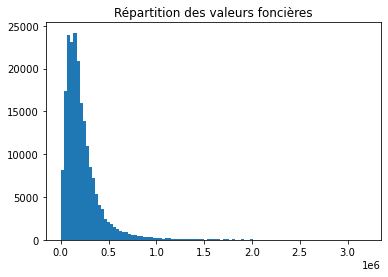

In [32]:
# Répartition des prix de vente :

plt.hist(data["valeur_fonciere"].values, bins = 100)
plt.title('Répartition des valeurs foncières')

Il y a encore des valeurs extrêmes qui **gênent la visualisation**. Nous allons **renlever les valeurs extrêmes** pour pouvoir mieux observer les données (nous enlevons les valeurs foncières dont l'écart à la moyenne est supérieur à 2,5 fois l'écart type). 

**Attention** : nous n'enlevons pas ces données de notre dataset principal (pour cela, nous créons data_aux).

On constate que la distribution est celle d'une **loi exponentielle**.

N.B. : nous utilisons également **le package seaborn** qui offre de bonnes opportunités de visualisation.

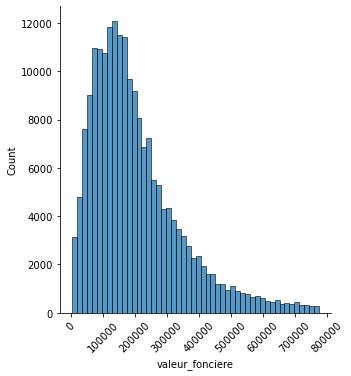

In [33]:
data_aux = data[~(np.abs(data['valeur_fonciere'] - data['valeur_fonciere'].mean()) > (2.5 * data['valeur_fonciere'].std()))]

sns.displot(data_aux, 
            x = "valeur_fonciere", 
            bins = 50)
plt.xticks(rotation = 45)
plt.show()

Distinguons les **types de biens** désormais :

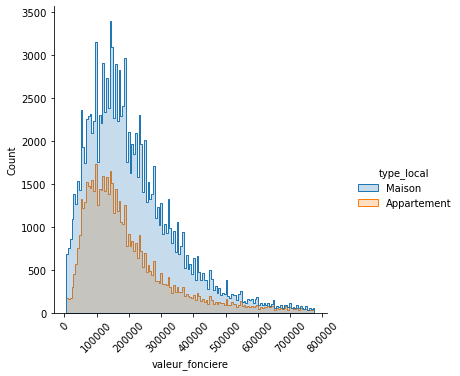

In [34]:
data_aux = data_aux.drop(data_aux.loc[data_aux['type_local'] == 'Local industriel. commercial ou assimilé'].index)

sns.displot(data = data_aux,
            x = "valeur_fonciere",
            hue = "type_local",
            element = "step")

plt.xticks(rotation = 45)
plt.show()

On constate sur ce graphique que, dans ce dataset ("data_aux"), **les valeurs foncières des maisons sont sont en moyenne légèrement plus élevées que celles des appartements**. Cependant, cela est lié au fait que **nous avons tronqué le dataset**.

In [46]:
print(f"Prix moyen des maisons : {np.round(data.loc[data['type_local'] == 'Maison']['valeur_fonciere'].mean())}")
print(f"Prix moyen des appartements : {np.round(data.loc[data['type_local'] == 'Appartement']['valeur_fonciere'].mean())}")

print(f"Ecart-type des prix des maisons : {np.round(data.loc[data['type_local'] == 'Maison']['valeur_fonciere'].std())}")
print(f"Ecart-type des prix des appartements : {np.round(data.loc[data['type_local'] == 'Appartement']['valeur_fonciere'].std())}")

Prix moyen des maisons : 223647.0
Prix moyen des appartements : 227679.0
Ecart-type des prix des maisons : 190528.0
Ecart-type des prix des appartements : 237637.0


En effet, le prix moyen des appartements est très légèrement plus élevé que le prix moyen des maisons mais **l'écart-type des prix des appartements est sensiblement plus élevé que celui des maisons**.

Cela s'interprète par le fait que **les appartements dans les centres grandes villes sont largement majoritaires et très chers** (il y a peu de maisons dans ces zones, s'il y en a elles sont très très chères mais il y a trop peu pour que cela ait un impact sur la variance).

### 3.3. Corrélation entre valeur foncière et surface :

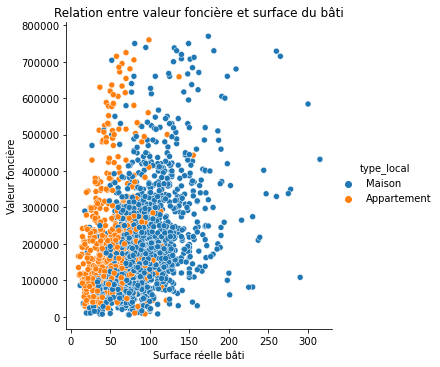

In [47]:
# Représentation des transactions d'appartements et maisons : valeur foncière en fonction de la surface

data_aux = data_aux.drop(data_aux.loc[data_aux['type_local'] == 'Dépendance'].index)

ax = sns.relplot(x = "surface_reelle_bati", 
            y = "valeur_fonciere", 
            hue = "type_local", 
            data = data_aux.sample(2000))
ax.set(title = "Relation entre valeur foncière et surface du bâti",
       xlabel = "Surface réelle bâti", ylabel = "Valeur foncière")
plt.show()

On ne constate **pas une corrélation très marquée**... En effet, il faudrait **distinguer la localisation** du bien (Paris vs. petite ville vs. campagne).

### 3.4. Premières intuitions sur l'analyse à l'échelle départementale :

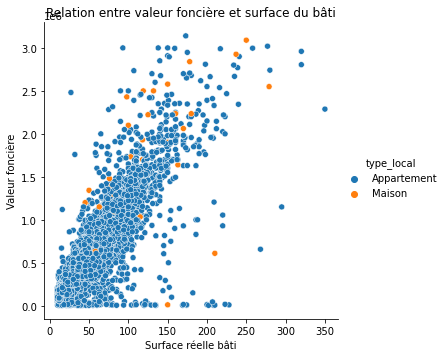

In [36]:
# Représentation des transactions d'appartements et maisons pour Paris

data_aux_paris = data.drop(data.loc[data['code_departement'] != "75"].index)

data_aux_paris = data_aux_paris.drop(data_aux_paris.
                                     loc[data_aux_paris['type_local'] =='Local industriel. commercial ou assimilé'].index)

ax = sns.relplot(x = "surface_reelle_bati", 
            y = "valeur_fonciere", 
            hue = "type_local", 
            data = data_aux_paris.sample(10000))
ax.set(title = "Relation entre valeur foncière et surface du bâti",
       xlabel = "Surface réelle bâti", ylabel = "Valeur foncière")
plt.show()

**Observation de la corrélation** avec lmplot :

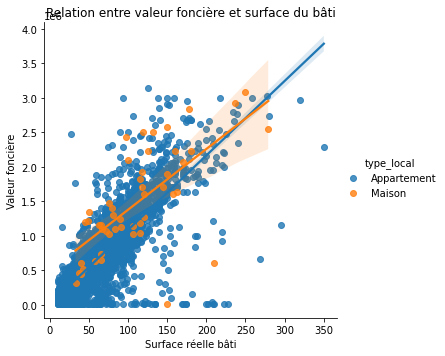

In [37]:
ax = sns.lmplot(x = "surface_reelle_bati", 
            y = "valeur_fonciere", 
            hue = "type_local", 
            data = data_aux_paris.sample(10000))
ax.set(title = "Relation entre valeur foncière et surface du bâti",
       xlabel = "Surface réelle bâti", ylabel = "Valeur foncière")
plt.show()

Pour la ville de Paris, la corrélation est très marquée !

(1818, 25)

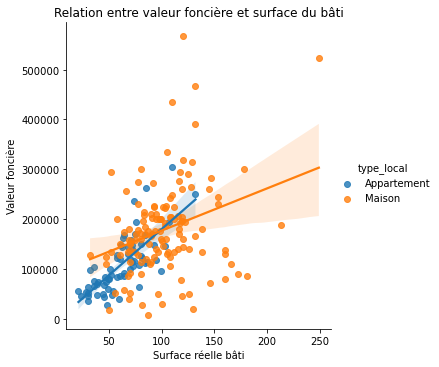

In [38]:
# Représentation des transactions d'appartements et maisons pour le Finistère

data_aux_finistere = data.drop(data.loc[data['code_departement'] != "29"].index)
data_aux_finistere = data_aux_finistere.drop(data_aux_finistere.loc[data_aux_finistere['type_local'] == 'Local industriel. commercial ou assimilé'].index)
display(data_aux_finistere.shape)

ax = sns.lmplot(x = "surface_reelle_bati", 
            y = "valeur_fonciere", 
            hue = "type_local", 
            data = data_aux_finistere.sample(200))
ax.set(title = "Relation entre valeur foncière et surface du bâti",
       xlabel = "Surface réelle bâti", ylabel = "Valeur foncière")
plt.show()

### 3.5. Analyse par département :

Les cinq départements où les prix moyens des transaction sont les plus élevés :


,valeur_fonciere
code_departement,
75,526786.852328
92,488236.944912
94,362367.437919
78,359608.717007
973,342219.686011


Visualisation graphique des 20 départements où les prix moyens des transaction sont les plus élevés :


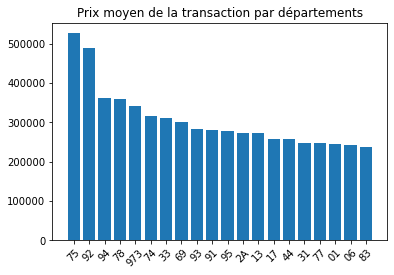

In [69]:
# Les départements où les prix moyens des transaction sont les plus élevés :

ranking_dpt_mean_price = data.groupby("code_departement")["valeur_fonciere"].mean().sort_values(ascending = False)

print("Les cinq départements où les prix moyens des transaction sont les plus élevés :")
display(pd.DataFrame(ranking_dpt_mean_price).head(5))

print("Visualisation graphique des 20 départements où les prix moyens des transaction sont les plus élevés :")
fig, axs = plt.subplots()
axs.set(title = "Prix moyen de la transaction par départements")
axs.bar(x = [str(dep) for dep in ranking_dpt_mean_price.head(20).index.unique()],
            height = ranking_dpt_mean_price.head(20) )
plt.xticks(rotation = 45)
plt.show()

Sans surprise, **les départements de la région parisienne sont en tête du classement** des départements où les prix moyens des transaction sont les plus élevés.

Les cinq départements où il y a eu le plus de transactions :


,valeur_fonciere
code_departement,
59,12403
75,11553
33,7925
44,7170
77,6142


Visualisation graphique des 20 départements où il y a eu le plus de transactions :


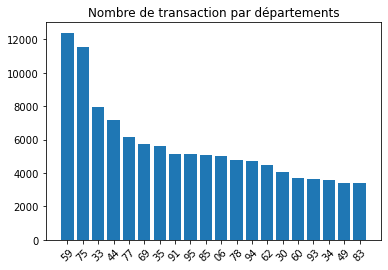

In [70]:
# Les départements où il y a eu le plus de transactions :

ranking_dpt_nb = data.groupby("code_departement")["valeur_fonciere"].count().sort_values(ascending = False)
print("Les cinq départements où il y a eu le plus de transactions :")
display(pd.DataFrame(ranking_dpt_nb).head(5))

print("Visualisation graphique des 20 départements où il y a eu le plus de transactions :")
fig, axs = plt.subplots()
axs.set(title = "Nombre de transaction par départements")
axs.bar(x = [str(dep) for dep in ranking_dpt_nb.head(20).index.unique()],
            height = ranking_dpt_nb.head(20) )
plt.xticks(rotation = 45)
plt.show()

Les cinq départements où les nombres moyens de m2 sont les plus élevés :


,surface_reelle_bati
code_departement,
48,144.864865
55,122.329114
32,116.188725
70,113.757188
01,111.461296


Visualisation graphique des 20 départements où les nombres moyens de m2 sont les plus élevés :


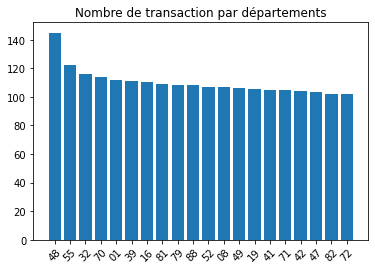

In [72]:
# Les départements où les nombres moyens de m2 sont les plus élevés :

ranking_dpt_nb_m2 = data.groupby("code_departement")["surface_reelle_bati"].mean().sort_values(ascending = False)
print("Les cinq départements où les nombres moyens de m2 sont les plus élevés :")
display(pd.DataFrame(ranking_dpt_nb_m2).head(5))

print("Visualisation graphique des 20 départements où les nombres moyens de m2 sont les plus élevés :")
fig, axs = plt.subplots()
axs.set(title = "Nombre de transaction par départements")
axs.bar(x = [str(dep) for dep in ranking_dpt_nb_m2.head(20).index.unique()],
            height = ranking_dpt_nb_m2.head(20) )
plt.xticks(rotation = 45)
plt.show()

### 3.6. QQ-plot :

Les QQ-plot pour la variable "valeurs foncières" correspondent à ceux d'une **distribution exponentielle**, ce qui confirme notre intuition sur la répartition des valeurs foncières.

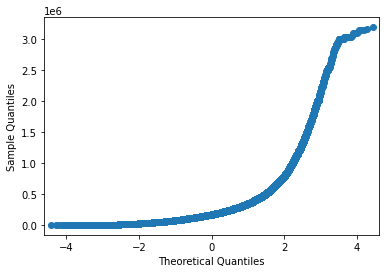

In [74]:
sm.qqplot(data["valeur_fonciere"])
plt.show()

((array([-4.50166856, -4.30945699, -4.20513588, ...,  4.20513588,
          4.30945699,  4.50166856]),
  array([   5000.,    5000.,    5000., ..., 3150000., 3169650., 3190000.])),
 (179573.3822637566, 227573.38086462984, 0.8201578394525223))

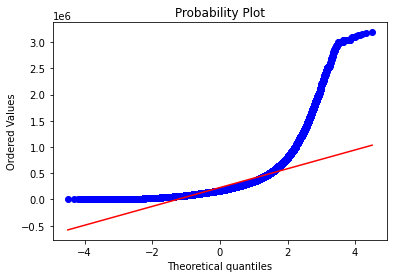

In [76]:
stats.probplot(data["valeur_fonciere"], plot = plt)

### 3.7. Représentation cartographique :

In [110]:
sub_data = data[data['code_departement'] == "75"]
sub_data = sub_data[sub_data['longitude'].notna()]
sub_data = sub_data[sub_data['latitude'].notna()]
sub_data = sub_data.sample(1000).reset_index()

In [113]:
paris = folium.Map(location = [48.856578, 2.351828], zoom_start = 12)
coord = [float(sub_data['latitude'][0]), float(sub_data['longitude'][0])]
id_ = str(sub_data["identifiant_transaction"][0]) + "au prix : " + str(sub_data["valeur_fonciere"][0])
folium.CircleMarker(coord, 
                    popup = id_, 
                    radius = 2).add_to(paris)

for index in tqdm(range(sub_data.shape[0]), desc = "Progression"):
    coord = [float(sub_data["latitude"][index]), float(sub_data["longitude"][index])]
    id_ = str(sub_data["identifiant_transaction"][index]) + " au prix : " + str(sub_data["valeur_fonciere"][index])
    folium.CircleMarker(coord, 
                        popup = id_, 
                        radius = 2).add_to(paris)
    
paris

Progression: 100%|██████████| 1000/1000 [00:01<00:00, 686.93it/s]


In [116]:
sub_data = data[data['longitude'].notna()]
sub_data = sub_data[sub_data['latitude'].notna()]
sub_data = sub_data.sample(10000).reset_index()

In [ ]:
france = folium.Map(location = [46.227638, 2.213749], zoom_start = 5)
coord = [float(sub_data['latitude'][0]), float(sub_data['longitude'][0])]
id_ = str(sub_data["identifiant_transaction"][0]) + "au prix : " + str(sub_data["valeur_fonciere"][0])
folium.CircleMarker(coord, 
                    popup = id_, 
                    radius = 2).add_to(france)

for index in tqdm(range(sub_data.shape[0]), desc = "Progression"):
    coord = [float(sub_data["latitude"][index]), float(sub_data["longitude"][index])]
    id_ = str(sub_data["identifiant_transaction"][index]) + " au prix : " + str(sub_data["valeur_fonciere"][index])
    folium.CircleMarker(coord, 
                        popup = id_, 
                        radius = 2).add_to(france)
    
france

Progression: 100%|██████████| 10000/10000 [00:15<00:00, 632.88it/s]


In [52]:
# lien tuto folium : https://fxjollois.github.io/cours-2016-2017/analyse-donnees-massives-tp9.html

# Etape 4 : modélisation

**Imports pour la modélisation**

In [53]:
from sklearn.metrics import make_scorer
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

In [54]:
# data_model = data[data["valeur_fonciere"] > 0.0] # A priori plus nécessaire car fait plus haut
data_model = data

**Concernant le choix des métriques d'évaluation des modèles** 
Ici on cherche à prédire le plus précisemment possible la valeur du logement à partir de ses caractéristiques.
Les métriques utilisées pour l'instant sont :
- *Explained_variance_score* qui correspond à la part de variance dans le y_pred que le modèle explique
- *mean_squarred_error* "expected value of the squarred error"
- MAPE codée en-dessous, mean absolute percentage error, mesure de la précision comme un pourcentage  

Etant donné que ce qui nous intéresse dans ce projet est de prédire précisemment le prix du logement, la métrique **MAPE** 
semble la plus pertinente puisqu'elle nous donne une mesure en pourcentage de la précision de notre estimation (ou plutôt de l'écart en % de notre prédiction à la réalité).

In [55]:
# Features selection

features = ['valeur_fonciere', 'type_local', 'surface_reelle_bati', 'nombre_pieces_principales', 
            'nature_culture', 'surface_terrain', 'longitude', 'latitude', 'code_departement', 'prix_m2']

data_model = data_model[features]

Etant donné que le modèle de randomforest de sklearn ne peut pas gérer seul les variables catégorielles, nous devons les 
transformer en dummies

In [56]:
# Encoding categorical variables

# local_type

data_model["encoded_local_type_m"] = [1 if local == "Maison" else 0 for local in data_model["type_local"]]
data_model["encoded_local_type_a"] = [2 if local == "Appartement" else 0 for local in data_model["type_local"]]
data_model["encoded_local_type_d"] = [3 if local == "Dépendance" else 0 for local in data_model["type_local"]]
data_model["encoded_local_type_l"] = [4 if local == "Local industriel. commercial ou assimilé" else 0 \
                                      for local in data_model["type_local"]]


list_name = ["type_local", "encoded_local_type_m", "encoded_local_type_a", "encoded_local_type_d", 
             "encoded_local_type_l"]

data_model["encoded_local_type"] = data_model.loc[:,list_name].sum(axis = 1)
data_model = data_model.drop(list_name, axis = 1)

# nature_culture

data_model["encoded_nature_culture_c"] = [1 if local == "culture" else 0 for local in data_model["nature_culture"]]
data_model["encoded_nature_culture_s"] = [2 if local == "sols" else 0 for local in data_model["nature_culture"]]
data_model["encoded_nature_culture_tb"] = [3 if local == "terrains a bâtir" else 0 for local in data_model["nature_culture"]]
data_model["encoded_nature_culture_j"] = [4 if local == "jardins" else 0 for local in data_model["nature_culture"]]
data_model["encoded_nature_culture_ta"] = [4 if local == "terrains d'agrément" else 0 for local in data_model["nature_culture"]]

list_name = ["nature_culture", "encoded_nature_culture_c", "encoded_nature_culture_s", 
             "encoded_nature_culture_tb", "encoded_nature_culture_j", "encoded_nature_culture_ta"]

data_model["encoded_nature_culture"] = data_model.loc[:,list_name].sum(axis = 1)

data_model = data_model.drop(list_name, axis = 1)

# code_departement

data_model["code_departement"] = [201 if code == "2A" else code for code in data_model["code_departement"]]
data_model["code_departement"] = [202 if code == "2B" else code for code in data_model["code_departement"]]

# enlever NaN (on les remplace par des 0, à justifier)
data_model = data_model.fillna(0)

data_model.head()

C:\Users\leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,code_departement,prix_m2,encoded_local_type,encoded_nature_culture
0,204332.0,88.0,4.0,866.0,5.157688,46.200988,01,0.004238,1,2
1,226700.0,96.0,3.0,0.0,5.108604,46.244066,01,0.000000,1,0
2,185000.0,100.0,4.0,703.0,5.210226,46.187698,01,0.003800,1,2
3,114500.0,85.0,2.0,87.0,5.174845,46.368874,01,0.000760,1,2
4,145000.0,92.0,1.0,2480.0,5.200760,46.405032,01,0.017103,1,2


**Régression linéaire simple**

In [57]:
data_model_small = data_model.copy()
data_model_small.head()

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,code_departement,prix_m2,encoded_local_type,encoded_nature_culture
0,204332.0,88.0,4.0,866.0,5.157688,46.200988,01,0.004238,1,2
1,226700.0,96.0,3.0,0.0,5.108604,46.244066,01,0.000000,1,0
2,185000.0,100.0,4.0,703.0,5.210226,46.187698,01,0.003800,1,2
3,114500.0,85.0,2.0,87.0,5.174845,46.368874,01,0.000760,1,2
4,145000.0,92.0,1.0,2480.0,5.200760,46.405032,01,0.017103,1,2


In [58]:
data_model_small = data_model_small[["surface_reelle_bati", "valeur_fonciere"]]
data_model_small.head()

,surface_reelle_bati,valeur_fonciere
0,88.0,204332.0
1,96.0,226700.0
2,100.0,185000.0
3,85.0,114500.0
4,92.0,145000.0


In [59]:
# Entraînement du modèle régression linéaire simple

training_data, test_data = train_test_split(data_model_small, test_size = 0.2)
y_train = training_data["valeur_fonciere"].values
X_train = training_data.drop(["valeur_fonciere"], axis = 1).values

model = LinearRegression(fit_intercept = True).fit(X_train, y_train)

In [60]:
# Test du modèle régression linéaire simple

y_test = test_data["valeur_fonciere"].values
X_test = test_data.drop(["valeur_fonciere"], axis = 1).values
y_pred = model.predict(X_test)

In [61]:
# Coefficients du modèle régression linéaire simple

print("Intercept: \n", model.intercept_)
print("Coefficients: \n", model.coef_)

Intercept: 
 163033.37377594862
Coefficients: 
 [715.22951122]


In [62]:
# Métriques du modèle régression linéaire simple

display("Variance expliquée par le modèle régression linéaire simple :")
display(explained_variance_score(y_test, y_pred))

display("MAPE")
display(mean_absolute_percentage_error(y_test, y_pred))

display("MSE")
display(mean_squared_error(y_test, y_pred))

display("R2")
display(r2_score(y_test, y_pred))

'Variance expliquée par le modèle régression linéaire simple :'

0.07336905817805262

'MAPE'

1.1775016392560609

'MSE'

45620036135.22601

'R2'

0.07335822724296659

Ce modèle extrêmement simple explique seulement **7%** de la variance dans les données de test

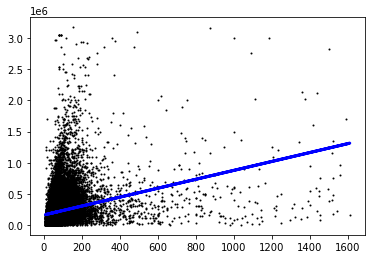

In [63]:
fig, axs = plt.subplots()
axs.scatter(X_test, y_test, color = "black", s = 1)
axs.plot(X_test, y_pred, color = "blue", linewidth = 3)
plt.show()

Le graphique ci-dessus indique les vrais points de données (en noir) et la droite de la régression linéaire simple (en bleue)

**Régression linéaire multiple**

In [64]:
# Entraînement du modèle régression linéaire multiple

# code_departement ? Pas ajoutable en l'état parce qu'il induirait un ordre entre le départemetn ce qui n'est pas ce qu'on veut

training_data, test_data = train_test_split(data_model[["valeur_fonciere","surface_reelle_bati", "nombre_pieces_principales",
                                                       "surface_terrain", "encoded_local_type", "encoded_nature_culture"]],
                                            test_size = 0.2)

y_train = training_data["valeur_fonciere"].values
X_train = training_data.drop(["valeur_fonciere"], axis = 1).values

model = LinearRegression(fit_intercept = True).fit(X_train, y_train)

In [65]:
# Test du modèle régression linéaire multiple

y_test = test_data["valeur_fonciere"].values
X_test = test_data.drop(["valeur_fonciere"], axis = 1).values
y_pred = model.predict(X_test)

In [66]:
# Coefficients du régression linéaire multiple
print("Intercept: \n", model.intercept_)
print("Coefficients: \n", model.coef_)

Intercept: 
 48352.98017583709
Coefficients: 
 [ 6.51061394e+02  3.43182893e+04  3.99769470e+00  2.85296588e+04
 -3.17781303e+04]


In [67]:
# Métriques du modèle régression linéaire multiple

display("Variance expliquée par le modèle régression linéaire multiple :")
display(explained_variance_score(y_test, y_pred))

display("MAPE")
display(mean_absolute_percentage_error(y_test, y_pred))

display("MSE")
display(mean_squared_error(y_test, y_pred))

display("R2")
display(r2_score(y_test, y_pred))

'Variance expliquée par le modèle régression linéaire multiple :'

0.12431589450132063

'MAPE'

1.0488041189526345

'MSE'

43005972969.85164

'R2'

0.12430720766368786

Dans mon test, on monte à seulement **12 %** de variance expliquée en rajoutant plein de variables

**Random forest**

In [68]:
# Entraînement du modèle random forest

training_data, test_data = train_test_split(data_model, test_size = 0.2)

y_train = training_data["valeur_fonciere"].values
X_train = training_data.drop(["valeur_fonciere", "prix_m2"], axis = 1).values

model = RandomForestRegressor(n_estimators = 30, min_samples_split = 5)

model.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=5, n_estimators=30)

In [69]:
# Test du modèle random forest

y_test = test_data["valeur_fonciere"].values
X_test = test_data.drop(["valeur_fonciere", "prix_m2"], axis = 1).values
y_pred = model.predict(X_test)

display("Variance expliquée par le modèle")
display(explained_variance_score(y_test, y_pred))

'Variance expliquée par le modèle'

0.6908983953903214

In [70]:
# Métriques du modèle random forest

display("Variance expliquée par le modèle random forest :")
display(explained_variance_score(y_test, y_pred))

display("MAPE")
display(mean_absolute_percentage_error(y_test, y_pred))

display("MSE")
display(mean_squared_error(y_test, y_pred))

display("R2")
display(r2_score(y_test, y_pred))

'Variance expliquée par le modèle random forest :'

0.6908983953903214

'MAPE'

0.5436566534402207

'MSE'

14809711000.212326

'R2'

0.6908519747165749

Text(0.5, 1.0, "Distribution de l'erreur de notre modèle")

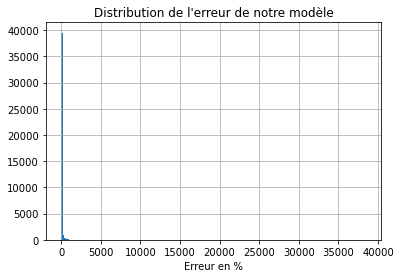

In [71]:
schema = pd.DataFrame((np.abs(y_test - model.predict(X_test)) / y_test)) * 100

schema.hist(bins = 200)

plt.xlabel('Erreur en %')
plt.title('Distribution de l\'erreur de notre modèle')